# Products

In this notebook, we analyze the products sold using the Olist marketplace.

We will look for answers to the following questions:
- How many different categories of products are there?
- Which category generates the most revenue?
- Does the 80/20 rule apply to the sale of products in this store?

Importing Python libraries in order to make some possible visualizations.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Establishing connection to the database.

In [2]:
%load_ext sql
%sql sqlite:///data/olist.db

'Connected: @data/olist.db'

For the analysis in this notebook, we will use the same tables as in the first one:
- 'orders'
- 'order_items'
- 'order_payments
- 'products'
- 'products_translation'  

For this analysis, the table 'order_items' is crucial, where information about the number of specific products purchased under each order is stored. In the previous notebook ("Order and payments) I analyzed the sum of revenues in the Olist store and then I took into account the total amount that the customer payments (cost of the product + shipping). Here I will take into account the price of the product itself and treat it as revenue (from the point of seller).

### How many different categories of products are there?

At the beginning, we check how many product categories there are in the entire data set.

In [13]:
%%sql
SELECT COUNT(DISTINCT product_category_name) AS category_qty FROM products;

 * sqlite:///olist.db
Done.


category_qty
73


You can then see how many different products there are within each category.

In [33]:
%%sql 
SELECT products_translation.product_category_name_english AS category, COUNT(DISTINCT products.product_id) AS products_qty FROM products
LEFT JOIN products_translation ON products.product_category_name=products_translation.product_category_name
GROUP BY products_translation.product_category_name
ORDER BY products_qty DESC
LIMIT 20;

 * sqlite:///olist.db
Done.


category,products_qty
bed_bath_table,3029
sports_leisure,2867
furniture_decor,2657
health_beauty,2444
housewares,2335
auto,1900
computers_accessories,1639
toys,1411
watches_gifts,1329
telephony,1134


### Which category generates the most revenue?

In the first query, there are ranked categories in terms of revenue over the entire sales period (2016-18). The first 3 places with a total revenue of over RBL 1,000,000 are occupied by the following categories: *health_beauty*, *watches_gifts*, *bed_bath_table*.

In [28]:
%%sql
SELECT products_translation.product_category_name_english AS category, ROUND(SUM(a.total_sum),2) AS total_revenue FROM
(SELECT product_id, SUM(price) AS total_sum FROM order_items
GROUP BY product_id
ORDER BY total_sum DESC) AS a
LEFT JOIN products ON a.product_id=products.product_id
LEFT JOIN products_translation ON products.product_category_name=products_translation.product_category_name
GROUP BY products_translation.product_category_name
ORDER BY total_revenue DESC
LIMIT 10;

 * sqlite:///olist.db
Done.


category,total_revenue
health_beauty,1258681.34
watches_gifts,1205005.68
bed_bath_table,1036988.68
sports_leisure,988048.97
computers_accessories,911954.32
furniture_decor,729762.49
cool_stuff,635290.85
housewares,632248.66
auto,592720.11
garden_tools,485256.46


Below is a query that displays the most profitable category each year.

In [27]:
%%sql
SELECT year, category, price_sum AS total_revenue FROM (SELECT a.year, a.category, a.price_sum, 
RANK () OVER (
    PARTITION BY a.year 
    ORDER BY price_sum DESC) 
    revenue_rank FROM
(SELECT STRFTIME("%Y",o.order_purchase_timestamp) AS year, t.product_category_name_english AS category, ROUND(SUM(i.price),2) AS price_sum FROM order_items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN products p ON i.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY STRFTIME("%Y",o.order_purchase_timestamp), p.product_category_name) AS a
)
WHERE revenue_rank = 1;

 * sqlite:///olist.db
Done.


year,category,total_revenue
2016,furniture_decor,5880.78
2017,bed_bath_table,498440.43
2018,health_beauty,772238.15


Based on the previous query, you can easily create a table that shows the TOP 5 categories in terms of revenue each year.  
The 'rank' column defines the position in terms of revenue in a given year.


In [30]:
%%sql
SELECT year, category, price_sum AS total_revenue, revenue_rank AS rank FROM (SELECT a.year, a.category, a.price_sum, 
RANK () OVER (
    PARTITION BY a.year 
    ORDER BY price_sum DESC) 
    revenue_rank FROM
(SELECT STRFTIME("%Y",o.order_purchase_timestamp) AS year, t.product_category_name_english AS category, ROUND(SUM(i.price),2) AS price_sum FROM order_items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN products p ON i.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY STRFTIME("%Y",o.order_purchase_timestamp), p.product_category_name) AS a
)
WHERE revenue_rank <= 5;

 * sqlite:///olist.db
Done.


year,category,total_revenue,rank
2016,furniture_decor,5880.78,1
2016,perfumery,5688.7,2
2016,health_beauty,4687.48,3
2016,toys,4465.09,4
2016,consoles_games,3882.26,5
2017,bed_bath_table,498440.43,1
2017,watches_gifts,492794.5,2
2017,health_beauty,481755.71,3
2017,sports_leisure,452148.84,4
2017,computers_accessories,405078.69,5


Using the pandas and seaborn libraries, you can create a simple bar chart showing the revenues of subsequent product categories.

 * sqlite:///olist.db
Done.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '2016 furniture_decor'),
  Text(1, 0, '2016 perfumery'),
  Text(2, 0, '2016 health_beauty'),
  Text(3, 0, '2016 toys'),
  Text(4, 0, '2016 consoles_games'),
  Text(5, 0, '2017 bed_bath_table'),
  Text(6, 0, '2017 watches_gifts'),
  Text(7, 0, '2017 health_beauty'),
  Text(8, 0, '2017 sports_leisure'),
  Text(9, 0, '2017 computers_accessories'),
  Text(10, 0, '2018 health_beauty'),
  Text(11, 0, '2018 watches_gifts'),
  Text(12, 0, '2018 bed_bath_table'),
  Text(13, 0, '2018 sports_leisure'),
  Text(14, 0, '2018 computers_accessories')])

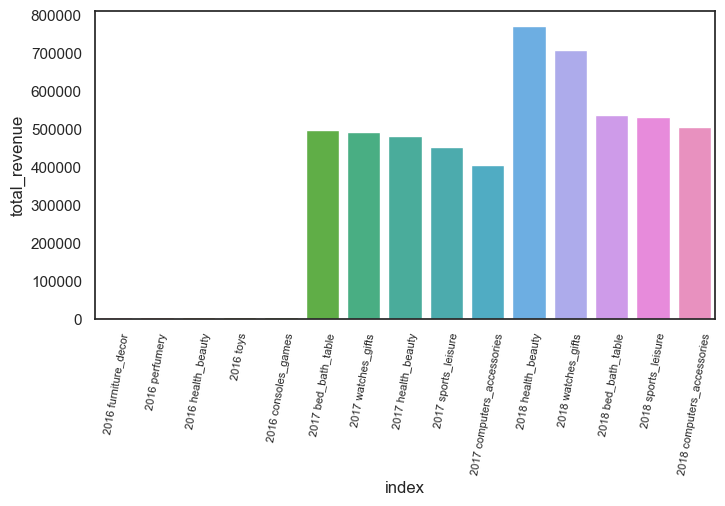

In [86]:
data = %sql SELECT year, category, price_sum AS total_revenue, revenue_rank AS rank FROM (SELECT a.year, a.category, a.price_sum, \
RANK () OVER (PARTITION BY a.year ORDER BY price_sum DESC) revenue_rank FROM \
(SELECT STRFTIME("%Y",o.order_purchase_timestamp) AS year, t.product_category_name_english AS category, ROUND(SUM(i.price),2) AS price_sum FROM order_items i \
LEFT JOIN orders o ON o.order_id=i.order_id \
LEFT JOIN products p ON i.product_id=p.product_id \
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name \
GROUP BY STRFTIME("%Y",o.order_purchase_timestamp), p.product_category_name) AS a) WHERE revenue_rank <= 5;

data = data.DataFrame()
data['index'] = data['year'] + str(' ') + data['category']

plt.figure(figsize = (8,4))
sns.set_style("white")
sns.barplot(data, x='index', y='total_revenue')
plt.xticks(rotation=80, fontsize=8)

### Does the 80/20 rule apply to the sale of products in this store?

The popular 80/20 rule (known as the Pareto principle) states that 80% of the consequences are due to 20% of the causes. We will try to see if this rule applies to the revenue generated by the various products in the Olist store.

We start with a query that displays the TOP 10 best-selling products ranked by total revenue.

In [19]:
%%sql
SELECT i.product_id, t.product_category_name_english AS category, COUNT(i.product_id) AS qty, i.price AS price, ROUND(SUM(i.price),2) AS total_sum FROM order_items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN products p ON i.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY i.product_id
ORDER BY total_sum DESC
LIMIT 10;

 * sqlite:///olist.db
Done.


product_id,category,qty,price,total_sum
bb50f2e236e5eea0100680137654686c,health_beauty,195,330.0,63885.0
6cdd53843498f92890544667809f1595,health_beauty,156,349.9,54730.2
d6160fb7873f184099d9bc95e30376af,computers,35,1300.0,48899.34
d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,343,149.0,47214.51
99a4788cb24856965c36a24e339b6058,bed_bath_table,488,74.0,43025.56
3dd2a17168ec895c781a9191c1e95ad7,computers_accessories,274,149.9,41082.6
25c38557cf793876c5abdd5931f922db,baby,38,1106.99,38907.32
5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,63,610.0,37733.9
53b36df67ebb7c41585e8d54d6772e08,watches_gifts,323,99.9,37683.42
aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,527,69.9,37608.9


In order to find products that brought in 80% of the revenue, it is best to add a 'running_total' column summing up the 'total_sum' revenue values from subsequent rows.  
At the end of the query there is a WHERE statement where we select only those products that brought 80% of the revenue (when the 'running_total' value is less than or equal to 0.8 * total_revenue).

In [18]:
%%sql
SELECT * FROM
(SELECT *, SUM(a.total_sum) OVER (ORDER BY a.total_sum DESC) AS running_total FROM
(SELECT i.product_id, t.product_category_name_english AS category, ROUND(SUM(i.price),2) AS total_sum FROM order_items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN products p ON i.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY i.product_id
ORDER BY total_sum DESC) AS a)
WHERE running_total <= ((SELECT SUM(price) FROM order_items)*0.8) 
LIMIT 10
;

 * sqlite:///olist.db
Done.


product_id,category,total_sum,running_total
bb50f2e236e5eea0100680137654686c,health_beauty,63885.0,63885.0
6cdd53843498f92890544667809f1595,health_beauty,54730.2,118615.2
d6160fb7873f184099d9bc95e30376af,computers,48899.34,167514.53999999998
d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,47214.51,214729.05
99a4788cb24856965c36a24e339b6058,bed_bath_table,43025.56,257754.61
3dd2a17168ec895c781a9191c1e95ad7,computers_accessories,41082.6,298837.20999999996
25c38557cf793876c5abdd5931f922db,baby,38907.32,337744.52999999997
5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,37733.9,375478.43
53b36df67ebb7c41585e8d54d6772e08,watches_gifts,37683.42,413161.85
aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,37608.9,450770.75


Now you can create a query that will display a simple table showing:
- **revenue80_qty** - the number of products that bring 80% of the revenue
- **revenue80_total** - 80% of total revenue
- **all_products_qty** - number of all products in the store
- **all_products_total** - total revenue in the store generated by all products
- **ratio** - ratio of the number of products responsible for 80% of the revenue to the number of all products

In [28]:
%%sql
SELECT COUNT(product_id) AS revenue80_qty, ROUND(SUM(total_sum),2) AS revenue80_total, (SELECT COUNT(DISTINCT product_id) FROM order_items) AS all_products_qty, (SELECT ROUND(SUM(price),2) FROM order_items) AS all_products_total, ROUND(CAST(COUNT(product_id) AS FLOAT)/(SELECT COUNT(DISTINCT product_id) FROM order_items),3) AS ratio FROM
(SELECT *, SUM(a.total_sum) OVER (ORDER BY a.total_sum DESC) AS running_total FROM
(SELECT i.product_id, t.product_category_name_english AS category, ROUND(SUM(i.price),2) AS total_sum FROM order_items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN products p ON i.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY i.product_id
ORDER BY total_sum DESC) AS a)
WHERE running_total <= ((SELECT SUM(price) FROM order_items)*0.8) ;

 * sqlite:///olist.db
Done.


revenue80_qty,revenue80_total,all_products_qty,all_products_total,ratio
8535,10873149.58,32951,13591643.7,0.259


As you can see, **26% of products generate 80% of the revenue**, so it can be assumed that the Pareto principle is very close in this case.

Finally, there is a query that displays the TOP 10 categories along with the number of products sold and the total revenue within the product group that generates 80% of the revenue.

In [26]:
%%sql
SELECT category, COUNT(product_id) AS qty, ROUND(SUM(total_sum)) as total_revenue FROM
(SELECT *, SUM(a.total_sum) OVER (ORDER BY a.total_sum DESC) AS running_total FROM
(SELECT i.product_id, t.product_category_name_english AS category, ROUND(SUM(i.price),2) AS total_sum FROM order_items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN products p ON i.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY i.product_id
ORDER BY total_sum DESC) AS a)
WHERE running_total <= ((SELECT SUM(price) FROM order_items)*0.8) 
GROUP BY category
ORDER BY total_revenue DESC
LIMIT 10;

 * sqlite:///olist.db
Done.


category,qty,total_revenue
watches_gifts,676,1095544.0
health_beauty,645,1056490.0
computers_accessories,531,781816.0
bed_bath_table,692,754874.0
sports_leisure,730,744164.0
cool_stuff,330,571306.0
furniture_decor,479,478393.0
housewares,427,446603.0
auto,415,437100.0
garden_tools,264,431266.0


In this case, only watches_gifts and health_beauty products generated total revenues above RBL 1,000,000 respectively.